In [1]:
import datetime
import warnings
warnings.filterwarnings('ignore')
import torch
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import KFold
import time
#from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
#from torch_poly_lr_decay import PolynomialLRDecay
import random
from torchvision import models
from sklearn.metrics import accuracy_score, log_loss
import math
import librosa

In [2]:
!nvidia-smi

Fri Feb  3 22:16:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
|  0%   28C    P8    24W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
torch.set_num_threads(8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# dir_in = "./datasets/train/africa"
# file_list = os.listdir(dir_in)
# for file in file_list:
#     if file.endswith(".wav"):
#         print(file)
#africa_ex1 = glob('dataset/train/africa/*.wav')

---

In [29]:
africa_ex1 = 'common_voice.wav'

In [3]:
import numpy as np
import librosa

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
        
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    
    return spec_db

In [52]:
get_melspectrogram_db(africa_ex1, sr=16000)

array([[-45.021706, -45.021706, -45.021706, ..., -28.46846 , -33.066696,
        -28.08957 ],
       [-45.021706, -45.021706, -45.021706, ..., -33.386353, -31.23667 ,
        -26.057806],
       [-45.021706, -45.021706, -45.021706, ..., -17.478779, -13.195372,
        -14.487791],
       ...,
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706],
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706],
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706]], dtype=float32)

In [30]:
data1, sr1 = librosa.load(africa_ex1, sr=16000)

In [55]:
data1.shape[0]

115584

In [58]:
data1[:5*16000].shape

(80000,)

In [63]:
africa_ex1 = 'common_voice.wav'
data1, sr1 = librosa.load(africa_ex1, sr=16000)
mel_africa_wav = librosa.feature.melspectrogram(data1, sr=16000, n_fft=2048, win_length=200, hop_length=160, n_mels=64)
mel_africa_wav

array([[0.00000000e+00, 0.00000000e+00, 1.09342108e-13, ...,
        3.92185996e-07, 1.39143395e-07, 3.39177888e-07],
       [0.00000000e+00, 0.00000000e+00, 1.09157238e-13, ...,
        9.95654887e-07, 1.94803462e-07, 8.49502499e-07],
       [0.00000000e+00, 0.00000000e+00, 1.08851005e-13, ...,
        1.34179049e-06, 1.75701445e-07, 1.12314069e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.49644865e-14, ...,
        8.29698266e-09, 9.12768083e-09, 3.21373572e-09],
       [0.00000000e+00, 0.00000000e+00, 4.43796746e-14, ...,
        2.39989895e-09, 3.32916317e-09, 1.76992021e-09],
       [0.00000000e+00, 0.00000000e+00, 8.99734236e-15, ...,
        5.83970441e-11, 1.12407923e-10, 1.88435836e-10]], dtype=float32)

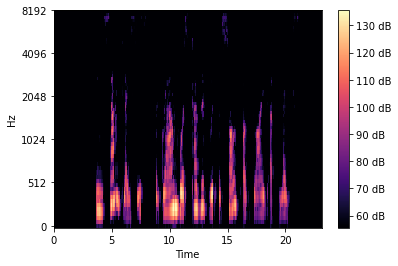

In [68]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(mel_africa_wav, ref=0.00002), sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.show()

In [69]:
def pad_or_truncate(x, audio_length):
    """Pad all audio to specific length."""
    length = len(x)
    if length <= audio_length:
        return np.concatenate((x, np.zeros(audio_length - length)), axis=0), length
    else:
        return x[:audio_length], audio_length


----

### path 지정

In [4]:
africa_train = sorted(glob("./datasets/train/africa/*.wav"))
australia_train = sorted(glob("./datasets/train/australia/*.wav"))
canada_train = sorted(glob("./datasets/train/canada/*.wav"))
england_train = sorted(glob("./datasets/train/england/*.wav"))
hongkong_train = sorted(glob("./datasets/train/hongkong/*.wav"))
us_train = sorted(glob("./datasets/train/us/*.wav"))

sample_submission = pd.read_csv("./datasets/sample_submission.csv")
#test_paths = [f'./datasets/test/{k}']

In [6]:
test_path = glob("./datasets/test/*.wav")

In [5]:
def load_data(paths):
    result = []
    for path in tqdm(paths):
        data, sr = librosa.load(path, sr=16000)
        result.append(data)
    result = np.array(result)
    
    return result

In [35]:
# africa_train_data = load_data(africa_train)
# np.save("./datasets/aftrica-sorted.npy", africa_train_data)

# australia_train_data = load_data(australia_train)
# np.save("./datasets/australia-sorted.npy", australia_train_data)

# canada_train_data = load_data(canada_train)
# np.save("./datasets/canada-sorted.npy", canada_train_data)

# england_train_data = load_data(england_train)
# np.save("./datasets/england-sorted.npy", england_train_data)

# hongkong_train_data = load_data(hongkong_train)
# np.save("./datasets/hongkong-sorted.npy", hongkong_train_data)

# us_train_data = load_data(us_train)
# np.save("./datasets/us-sorted.npy", us_train_data)

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [18:50<00:00,  8.84it/s]


In [44]:
# test_data = load_data(test_path) #6100개
# np.save("./datasets/test_npy.npy", test_data)

100%|█████████████████████████████████████████████████████████████████████████| 6100/6100 [13:22<00:00,  7.60it/s]


In [4]:
africa_train_data = np.load("./datasets/africa-sorted.npy", allow_pickle = True)
australia_train_data = np.load("./datasets/australia-sorted.npy", allow_pickle = True)
canada_train_data = np.load("./datasets/canada-sorted.npy", allow_pickle = True)
england_train_data = np.load("./datasets/england-sorted.npy", allow_pickle = True)
hongkong_train_data = np.load("./datasets/hongkong-sorted.npy", allow_pickle = True)
us_train_data = np.load("./datasets/us-sorted.npy", allow_pickle = True)
train_data_list = [africa_train_data, australia_train_data, canada_train_data, england_train_data, hongkong_train_data, us_train_data]

In [5]:
train_x = np.concatenate(train_data_list ,axis=0)
train_x.shape

(25520,)

-----

feature 자르기

`wav
  sr: 32000 
  window_size: 1024
  hop_length: 320
  mel_bins: 64
  `

In [11]:
def get_feature(data, sr=16000, n_fft=2048, win_length=200, hop_length=160, n_mels=64):
    
    mel = []
    for i in tqdm(data):
        mel_ = librosa.feature.melspectrogram(i, sr=sr, n_fft=n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
        mel.append(mel_)
    mel = np.array(mel)
    mel = librosa.power_to_db(mel, ref=np.max)
    #정규화를 여기서 해줘도 되고 , 뒤에서 데이터 다 만든후에 해줘도됨.
    
#     mel_mean = mel.mean()
#     mel = (mel - mel_mean)
    
    return mel


In [10]:
def set_length(data, d_mini):
    result = []
    for value in tqdm(data):
        value = value[:d_mini]
        if len(value) < d_mini:
            value = np.append(value, [0]*(d_mini-len(value))) #kinda padding
        result.append(value)
    result = np.array(result)
    
    return result

In [12]:
train_x

array([array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        1.3940811e-06, -1.0920638e-06,  1.0484886e-06], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -1.4028327e-05, -1.0613157e-05, -1.7424460e-05], dtype=float32),
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), ...,
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -2.5764151e-05,  1.5654117e-05,  2.3484859e-05], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        7.1461989e-05, -3.5540674e-05,  1.9304553e-05], dtype=float32)],
      dtype=object)

`win_length` : 음성을 작은 조각으로 자를때 작은 조각의 크기.   
`hop_length` : 음성을 작은 조각으로 자를때 자르는 간격  

In [13]:
train_x = set_length(train_x, 100000)

100%|██████████| 25520/25520 [00:12<00:00, 1995.69it/s]


In [14]:
train_x.shape

(25520, 100000)

In [15]:
# #train_x = np.concatenate(train_data_list ,axis=0)
# train_x_200 = get_feature(data = train_x, win_length=200)
# train_x_400 = get_feature(data = train_x, win_length=400)
# train_x_800 = get_feature(data = train_x, win_length=800)
# train_x_1000 = get_feature(data = train_x, win_length=1000)

# train_x_200 = train_x_200.reshape(train_x_200.shape[0], train_x_200.shape[1], train_x_200.shape[2], 1)
# train_x_400 = train_x_400.reshape(train_x_400.shape[0], train_x_400.shape[1], train_x_400.shape[2], 1)
# train_x_800 = train_x_800.reshape(train_x_800.shape[0], train_x_800.shape[1], train_x_800.shape[2], 1)
# train_x_1000 = train_x_1000.reshape(train_x_1000.shape[0], train_x_1000.shape[1], train_x_1000.shape[2], 1)


100%|██████████| 25520/25520 [04:44<00:00, 89.78it/s]


In [18]:
train_x_200.shape

(25520, 64, 626, 1)

In [16]:
train_reshape_list = [train_x_200, train_x_400, train_x_800, train_x_1000]
train_x_multi = np.concatenate(train_reshape_list, -1)
np.save('./datasets/train_x_multi.npy', train_x_multi)

In [22]:
train_reshape_list

[array([[[[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-51.2156948 ],
          [-51.29318657],
          [-36.53980915]],
 
         [[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-39.61816699],
          [-39.18733141],
          [-35.00829857]],
 
         [[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-32.3531565 ],
          [-32.59215093],
          [-33.75060227]],
 
         ...,
 
         [[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-64.15609322],
          [-70.52419645],
          [-56.33333863]],
 
         [[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-71.3021972 ],
          [-78.62044915],
          [-56.8433992 ]],
 
         [[-80.        ],
          [-80.        ],
          [-80.        ],
          ...,
          [-80.      

In [20]:
train_x_multi.shape

(25520, 64, 626, 4)

In [17]:
# test_x = np.load('./datasets/test_npy.npy', allow_pickle=True)

# test_x = set_length(test_x, 100000)
# test_x_200 = get_feature(data = test_x, win_length=200)
# test_x_400 = get_feature(data = test_x, win_length=400)
# test_x_800 = get_feature(data = test_x, win_length=800)
# test_x_1000 = get_feature(data = test_x, win_length=1000)


# test_x_200 = test_x_200.reshape(test_x_200.shape[0], test_x_200.shape[1], test_x_200.shape[2], 1)
# test_x_400 = test_x_400.reshape(test_x_400.shape[0], test_x_400.shape[1], test_x_400.shape[2], 1)
# test_x_800 = test_x_800.reshape(test_x_800.shape[0], test_x_800.shape[1], test_x_800.shape[2], 1)
# test_x_1000 = test_x_1000.reshape(test_x_1000.shape[0], test_x_1000.shape[1], test_x_1000.shape[2], 1)

# test_x_reshape = [test_x_200, test_x_400, test_x_800, test_x_1000]
# test_x_multi = np.concatenate(test_x_reshape, -1)
# np.save('./datasets/test_x_multi.npy', test_x_multi)

100%|██████████| 6100/6100 [01:06<00:00, 91.40it/s]


In [23]:
test_x_multi.shape

(6100, 64, 626, 4)

## model

In [6]:
class conv_bn_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(conv_bn_relu, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.BN = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.BN(x)
        x = self.relu(x)
        return x


In [22]:
conv_bn_relu(in_channels=4, out_channels=16, kernel_size=3)

conv_bn_relu(
  (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [8]:
class Network(nn.Module):
    def __init__(self, N):
        super(Network, self).__init__()
        self.N = N
        self.AveragePooling = nn.AvgPool2d(2)
        self.MaxPooling = nn.MaxPool2d(2)
        
        
        self.input_conv = conv_bn_relu(in_channels=4, out_channels=self.N, kernel_size=3)
        
        self.block1 = nn.Sequential(
            conv_bn_relu(in_channels=self.N*1, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*4, kernel_size=3),
            conv_bn_relu(in_channels=self.N*4, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*1, kernel_size=3),
        )
        
        self.block2 = nn.Sequential(
            conv_bn_relu(in_channels=self.N*1, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*4, kernel_size=3),
            conv_bn_relu(in_channels=self.N*4, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*1, kernel_size=3),
        )
        
        self.block3 = nn.Sequential(
            conv_bn_relu(in_channels=self.N*1, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*4, kernel_size=3),
            conv_bn_relu(in_channels=self.N*4, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*1, kernel_size=3),
        )
        
        self.block4 = nn.Sequential(
            conv_bn_relu(in_channels=self.N*1, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*4, kernel_size=3),
            conv_bn_relu(in_channels=self.N*4, out_channels=self.N*2, kernel_size=3),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*1, kernel_size=3),
        )
        
        self.pool_block = nn.Sequential(
            conv_bn_relu(in_channels=self.N*1, out_channels=self.N*2, kernel_size=3),
            nn.Dropout(0.15),
            nn.AvgPool2d(2),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*2, kernel_size=3),
            nn.Dropout(0.15),
            nn.AvgPool2d(2),
            conv_bn_relu(in_channels=self.N*2, out_channels=self.N*2, kernel_size=3),
            nn.Dropout(0.15),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.N*2, out_features=6),
        )
        
    def forward(self, x, out=''):
        x = self.input_conv(x)
        x = self.MaxPooling(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool_block(x)
        x=self.output(x)
        
        if out=='sigmoid':
            x = F.sigmoid(x)
        return x

In [9]:
for name,param in Network(16).named_parameters():
    print(f'name:{name}') 
    print(f'param.shape:{param.shape}') 
    print(f'param.requries_grad:{param.requires_grad}') 
    print('=====================================')

name:input_conv.conv.weight
param.shape:torch.Size([16, 4, 3, 3])
param.requries_grad:True
name:input_conv.conv.bias
param.shape:torch.Size([16])
param.requries_grad:True
name:input_conv.BN.weight
param.shape:torch.Size([16])
param.requries_grad:True
name:input_conv.BN.bias
param.shape:torch.Size([16])
param.requries_grad:True
name:block1.0.conv.weight
param.shape:torch.Size([32, 16, 3, 3])
param.requries_grad:True
name:block1.0.conv.bias
param.shape:torch.Size([32])
param.requries_grad:True
name:block1.0.BN.weight
param.shape:torch.Size([32])
param.requries_grad:True
name:block1.0.BN.bias
param.shape:torch.Size([32])
param.requries_grad:True
name:block1.1.conv.weight
param.shape:torch.Size([64, 32, 3, 3])
param.requries_grad:True
name:block1.1.conv.bias
param.shape:torch.Size([64])
param.requries_grad:True
name:block1.1.BN.weight
param.shape:torch.Size([64])
param.requries_grad:True
name:block1.1.BN.bias
param.shape:torch.Size([64])
param.requries_grad:True
name:block1.2.conv.weight
p

In [32]:
Network(16)

Network(
  (AveragePooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (input_conv): conv_bn_relu(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1): Sequential(
    (0): conv_bn_relu(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): conv_bn_relu(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): conv_bn_relu(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3

In [54]:
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [57]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        print(name)
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

input_conv.conv.weight
input_conv.conv.bias
input_conv.BN.weight
input_conv.BN.bias
block1.0.conv.weight
block1.0.conv.bias
block1.0.BN.weight
block1.0.BN.bias
block1.1.conv.weight
block1.1.conv.bias
block1.1.BN.weight
block1.1.BN.bias
block1.2.conv.weight
block1.2.conv.bias
block1.2.BN.weight
block1.2.BN.bias
block1.3.conv.weight
block1.3.conv.bias
block1.3.BN.weight
block1.3.BN.bias
block2.0.conv.weight
block2.0.conv.bias
block2.0.BN.weight
block2.0.BN.bias
block2.1.conv.weight
block2.1.conv.bias
block2.1.BN.weight
block2.1.BN.bias
block2.2.conv.weight
block2.2.conv.bias
block2.2.BN.weight
block2.2.BN.bias
block2.3.conv.weight
block2.3.conv.bias
block2.3.BN.weight
block2.3.BN.bias
block3.0.conv.weight
block3.0.conv.bias
block3.0.BN.weight
block3.0.BN.bias
block3.1.conv.weight
block3.1.conv.bias
block3.1.BN.weight
block3.1.BN.bias
block3.2.conv.weight
block3.2.conv.bias
block3.2.BN.weight
block3.2.BN.bias
block3.3.conv.weight
block3.3.conv.bias
block3.3.BN.weight
block3.3.BN.bias
bloc

210198

In [21]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network(16)
model.to(device)

summary(model, (4,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             592
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
      conv_bn_relu-4           [-1, 16, 16, 16]               0
         MaxPool2d-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 8, 8]           4,640
       BatchNorm2d-7             [-1, 32, 8, 8]              64
              ReLU-8             [-1, 32, 8, 8]               0
      conv_bn_relu-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
     conv_bn_relu-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 3

In [60]:
train_x.shape

(25520, 100000)

In [10]:
class VoiceDatasetSimple(Dataset):
        def __init__(self, X, y, transform, inference=False, roll=False):
            self.X = X
            self.y = y
            self.transform = transform
            self.inference = inference
            self.roll = roll
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            X = self.X[idx]
            X = (X-train_x_min)/(train_x_max-train_x_min)
            
            if self.inference:
                X = self.transform(X)
                return X
            else:
                if (self.roll==True) and (random.randint(0, 1)==1):
                    X = np.roll(X,random.randint(-200, 200), axis=1)
                    
                X = self.transform(X)    
                y = self.y[idx]
                
                onehot = np.zeros(6)
                onehot[y] = 1.
                y = onehot
                return X, y

In [11]:
def model_save(model, path):
    torch.save({'model':model.state_dict()}, path)

In [14]:
train_y = np.concatenate((np.zeros(len(africa_train_data), dtype = np.int),
                        np.ones(len(australia_train_data), dtype = np.int),
                         np.ones(len(canada_train_data), dtype = np.int) * 2,
                         np.ones(len(england_train_data), dtype = np.int) * 3,
                         np.ones(len(hongkong_train_data), dtype = np.int) * 4,
                         np.ones(len(us_train_data), dtype = np.int) * 5), axis = 0)

In [17]:
np.save("./datasets/train_y_sort.npy", train_y)

In [16]:
train_y.shape

(25520,)

In [26]:
for person in range(3):
    train_x = np.load('./datasets/train_x_multi.npy')
    train_y = np.load('./datasets/train_y_sort.npy')
    train_x_min = train_x.min()
    train_x_max = train_x.max()


    idx = [k+person for k in range(0, len(train_x), 3)][:-1]
    train_x=train_x[idx]
    train_y=train_y[idx]


    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    folds=[]
    for train_idx, valid_idx in skf.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

        
    for fold in range(5):
        epochs=35
        batch_size=128
        model_name = f'network-epoch{epochs}-person({person})-fold({fold}).pth'
        train_idx, valid_idx = folds[fold]

        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        train_dataset = VoiceDatasetSimple(X=train_x[train_idx], y=train_y[train_idx], transform=transform, roll=False)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

        valid_dataset = VoiceDatasetSimple(X=train_x[valid_idx], y=train_y[valid_idx], transform=transform)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


        # model compile
        model = Network(16).to(device)
        model = nn.DataParallel(model, device_ids=[0,1])
        
        
        # optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr =1e-3)
        Q = math.floor(len(train_dataset)/batch_size+1)*epochs/7
        lrs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = Q)
        
        # loss
        criterion = nn.CrossEntropyLoss()


        best = 9999
        for epoch in range(epochs):
            start = time.time()
            model.train()
            train_loss=0
            
            train_pred_list=[]
            train_true_list=[]
            train_log_loss=0
            
            for X, y in (train_loader):
                X = torch.tensor(X, dtype=torch.float32, device=device)
                y = torch.tensor(y, dtype=torch.float32 , device=device)

                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y.argmax(1))
                loss.backward()
                optimizer.step()
                lrs.step()

                train_pred_list += F.softmax(pred).argmax(1).detach().cpu().numpy().tolist()
                train_true_list += y.argmax(1).detach().cpu().numpy().tolist()
                train_loss+=loss.item()
                
            train_accuracy=accuracy_score(train_true_list, train_pred_list)


            #validation set
            with torch.no_grad():
                model.eval()
                valid_loss=0
                valid_log_loss=0
                valid_pred_list=[]
                valid_true_list=[]
                for X, y in (valid_loader):
                    X = torch.tensor(X, dtype=torch.float32, device=device)
                    y = torch.tensor(y, dtype=torch.float32 , device=device)

                    pred = model(X)
                    loss = criterion(pred, y.argmax(1))

                    valid_pred_list += F.softmax(pred).argmax(1).detach().cpu().numpy().tolist()
                    valid_true_list += y.argmax(1).detach().cpu().numpy().tolist()
                    valid_loss+=loss.item()

            valid_accuracy=accuracy_score(valid_true_list, valid_pred_list)

            
            if valid_loss/len(valid_loader) < best:
                model_save(model, f'./model/{model_name}')
                #model_name = f'network-epoch{epochs}-person({person})-fold({fold}).pth'

                best = valid_loss/len(valid_loader)

            print(f'===================== Epoch : {epoch+1}/{epochs}    time : {time.time()-start:.0f}s =====================')
            
            print(f'TRAIN -> loss : {train_loss/len(train_loader):.5f}     accuracy : {train_accuracy:.5f}')
            print(f'VALID -> loss : {valid_loss/len(valid_loader):.5f}     accuracy : {valid_accuracy:.5f}    best : {best:.5f}\n\n')

===================== Epoch : 1/35    time : 17s =====================
TRAIN -> loss : 1.49980     accuracy : 0.38771
VALID -> loss : 1.40071     accuracy : 0.40364    best : 1.40071


===================== Epoch : 2/35    time : 17s =====================
TRAIN -> loss : 1.34920     accuracy : 0.43651
VALID -> loss : 1.32063     accuracy : 0.43067    best : 1.32063


===================== Epoch : 3/35    time : 17s =====================
TRAIN -> loss : 1.32449     accuracy : 0.45973
VALID -> loss : 1.29589     accuracy : 0.48120    best : 1.29589


===================== Epoch : 4/35    time : 17s =====================
TRAIN -> loss : 1.29267     accuracy : 0.48707
VALID -> loss : 1.30803     accuracy : 0.46945    best : 1.29589


===================== Epoch : 5/35    time : 17s =====================
TRAIN -> loss : 1.27730     accuracy : 0.50808
VALID -> loss : 1.27086     accuracy : 0.49177    best : 1.27086


===================== Epoch : 6/35    time : 17s =====================
TRAI

In [27]:
X_test = np.load('./datasets/test_x_multi.npy')

test_dataset = VoiceDatasetSimple(X=X_test, y=None, transform=transform, inference=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=30, shuffle=False, num_workers=8)

result=0
for person in range(3):
    for fold in range(5):
        with torch.no_grad():
            weights = torch.load(f'./model/network-epoch{epochs}-person({person})-fold({fold}).pth')
            model.load_state_dict(weights['model'])
            model.eval()
            preds = []
            
            for X in tqdm(test_loader):
                X = torch.tensor(X, dtype=torch.float32, device=device)
                pred = F.softmax(model(X)).detach().cpu().numpy().tolist()
                preds+=pred
        preds = np.array(preds)
        result+=preds

100%|██████████| 204/204 [00:08<00:00, 25.34it/s]


In [31]:
pd.read_csv('sample_submission.csv')

,id,africa,australia,canada,england,hongkong,us
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...
6095,6096,0,0,0,0,0,0
6096,6097,0,0,0,0,0,0
6097,6098,0,0,0,0,0,0
6098,6099,0,0,0,0,0,0


In [34]:
print(result)
print(result.shape)
print(result/15)

[[ 0.31334412  0.73361432  0.63588197  8.346238    0.31911697  4.65180464]
 [ 0.71494263  1.50730311  1.33333371  6.34792918  0.29333935  4.80315232]
 [ 0.04651754  0.16694858  0.37291009  1.72701741  0.19022985 12.49637653]
 ...
 [ 0.79062995  0.52689598  0.71029282  4.35570826  0.60575328  8.01071981]
 [ 1.32944301  0.70592121  0.80506993  4.18037177  1.33073388  6.64846009]
 [ 0.39235762  0.77945921  1.03747175  3.85502675  0.96437984  7.97130488]]
(6100, 6)
[[0.02088961 0.04890762 0.04239213 0.55641587 0.02127446 0.31012031]
 [0.04766284 0.10048687 0.08888891 0.42319528 0.01955596 0.32021015]
 [0.00310117 0.01112991 0.02486067 0.11513449 0.01268199 0.83309177]
 ...
 [0.05270866 0.0351264  0.04735285 0.29038055 0.04038355 0.53404799]
 [0.08862953 0.04706141 0.05367133 0.27869145 0.08871559 0.44323067]
 [0.02615717 0.05196395 0.06916478 0.25700178 0.06429199 0.53142033]]
(6100, 6)


In [37]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1:] = result/15

In [38]:
submission

,id,africa,australia,canada,england,hongkong,us
0,1,0.020890,0.048908,0.042392,0.556416,0.021274,0.310120
1,2,0.047663,0.100487,0.088889,0.423195,0.019556,0.320210
2,3,0.003101,0.011130,0.024861,0.115134,0.012682,0.833092
3,4,0.064851,0.056437,0.062335,0.233133,0.036213,0.547031
4,5,0.256728,0.013920,0.021993,0.130895,0.059247,0.517218
...,...,...,...,...,...,...,...
6095,6096,0.015142,0.026397,0.016701,0.797693,0.010681,0.133387
6096,6097,0.205598,0.016208,0.023535,0.153146,0.061605,0.539907
6097,6098,0.052709,0.035126,0.047353,0.290381,0.040384,0.534048
6098,6099,0.088630,0.047061,0.053671,0.278691,0.088716,0.443231
